In [1]:
#
# Data Load/Transform Example 1: Loading Quantum Espresso band.x output
# file. This is an example of a relatively simple text based file format.
# Specifically, QE files contain "blocks" of x,y pairs separated by
# newlines. Each block corresponds to a distinct band, and all bands
# should share a common set of x values (wavevectors). A portion of
# such a file looks like:
#    0.0000   -6.7514     <--- band 1
#    0.0500   -6.7740
#    0.1000   -6.8388
#    ...
#    2.5588   -7.5918
#    2.6454   -7.6749
#    2.7321   -7.6998
# 
#    0.0000   -6.2509     <--- band 2
#    0.0500   -6.2536
#    0.1000   -6.2610
#    ...
# The precise spacing and numbers are file dependent, but the x and y
# columns are separated by one or more spaces, and bands by empty lines.
#
# The function load_bands loads this file using the Python csv module
# with space specified as the delimiter. Because multiple delimiters need
# to be merged into one, a line-by-line transform of the input is performed
# to treat consecutive delimiters as one, and remove any whitespace before
# the first column. This is done by combining strip, which removes leading
# and trailing whitespace, with a minifunction to reduce multiple whitespaces
# to single ones. The use of csv and this function is overkill for this
# specific file format, but is more extesnible to more complex variations,
# and enables robust error handling. 
#
# When merge=False, a 3D array indexed as band,row,column is returned. When
# merge=True, a 2D array indexed as x,band1-y,band2-y,band3-y,... is returned.
#
import csv
import logging
import numpy as np
def load_bands(file, merge=False):
    # condense whitespace
    def condenser(x):
        rv = x.strip()
        while '  ' in rv:
            rv = rv.replace('  ', ' ')
        return rv
    # rv will be a list containing lists, each one of which corresponds to
    # a single band.
    rv = []
    with open(file, "r", newline='') as f:
        # map applies condenser to each line returned by the iterator over the file f
        # condenser preprocesses each line so the csv reader can properly handle it.
        rdr = csv.reader(map(condenser,f),delimiter=' ')
        # rvgrp holds the rows for a single band
        rvgrp = []
        # process all rows
        i = 0
        for r in rdr:
            i += 1
            if len(r) == 0:
                # empty rows delineate separate bands. add existing band to our
                # master list, then reset for the next band. Generate a warning
                # if there are extra blank lines, as that might indicate a change
                # in the file format.
                if len(rvgrp) > 0:
                    rv.append(rvgrp)
                    rvgrp = []
                else:
                    logging.warning("Unexpected empty line on line %i", i)
            else:
                # The lines should contain two values, x and y, both numeric.
                # Emit warnings if that is not the case.
                try:
                    rvgrp.append([float(r[0]),float(r[1])])
                    if len(r) > 2:
                        logging.warning("Line %i has %i columns (expected 2)", i, len(r))
                except:
                    logging.warning("Unexpected non-numeric value on line %i", i)
    # Convert to a 3D array, indexed as band,row,column
    rv = np.array(rv)
    # If requested, transform to a 2D array indexed by row,column, with columns=x,band1-y,band2-y,...
    if merge:
        merged = None
        i = 0
        for ds in rv:
            i += 1
            if merged is None:
                merged = ds
            else:
                nds = ds
                if (ds.shape[0] != merged.shape[0]) or np.any(merged[:,0] != ds[:,0]):
                    logging.warning("Incomplete data found in band %i, interpolating.", i)
                    nds = np.interp(merged[:,0].ds[:,0],ds[:,1])
                merged = np.hstack((merged, ds[:,1].reshape((merged.shape[0],1))))
        rv = merged
    return rv

<IPython.core.display.Javascript object>


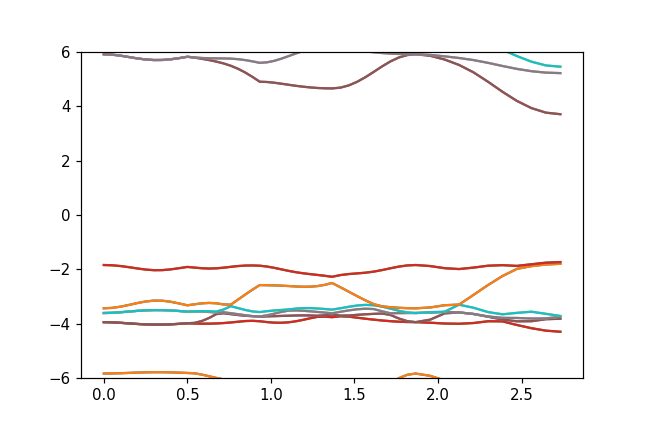

<IPython.core.display.Javascript object>


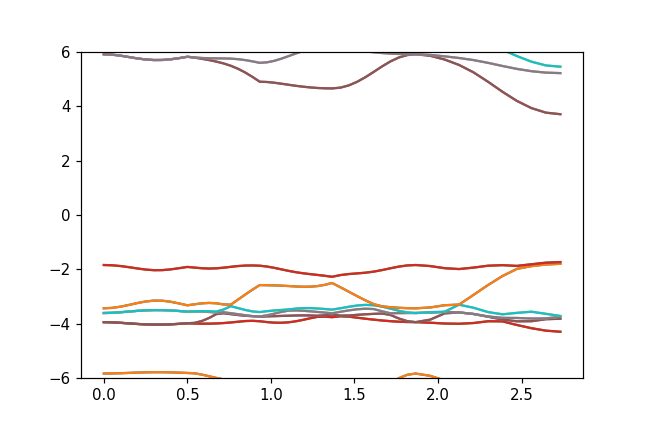

(-6, 6)

In [2]:
#
# Make sanity check plots for example 1: they should both work, and be the same.
#
data = load_bands("bands.out.gnu.txt")
datamerged = load_bands("bands.out.gnu.txt",merge=True)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for i in range(0,len(data)):
    plt.plot(data[i][:,0],data[i][:,1])
plt.ylim([-6,6])
plt.figure()
for i in range(1,datamerged.shape[1]):
    plt.plot(datamerged[:,0],datamerged[:,i])
plt.ylim([-6,6])


In [3]:
#
# Data Save/Transform Example 1: write a merged bands
# dataset as a comma separated value text file using
# the built-in python csv module.
#
datamerged = load_bands("bands.out.gnu.txt",merge=True)
with open("output-bands.csv","w",newline='') as f:
    wrt = csv.writer(f)
    for r in datamerged:
        wrt.writerow(r)

In [4]:
#
# Data Load/Transform Example 2: Loading a Bruker RAWv4 powder diffraction
# file. The Bruker RAWv4 file format is a poorly documented, proprietary
# binary (non-text) file format for x-ray diffraction data generated by
# Bruker diffractometers such as the D8 Advance and D8 Focus. Here, we 
# take advantage of an existing software module: 
#   xylib: https://github.com/wojdyr/xylib
# to do so. Somewhat confusingly, the v4 format is also sometimes called v3,
# and sometimes "v1.01". 
#
# The function load_xpd_raw loads a powder diffraction spectrum from a Bruker 
# raw file using xylib. It demonstrates keeping appropriate metadata with
# the data. It returns a dictionary containing two or more entries:
# 'meta' -> a dictionary of all metadata tags in the raw file
# 0,1,2... -> the individual 2-Theta/Intensity datasets from the file. A
# raw file can contain many spectra in a single file.
# 
import xylib
import numpy as np
def load_xpd_raw(file):
    rv = {}
    # load_file takes the filename as the first parameter, and the type as
    # the second parameter. An empty file type means "autodetect"
    f = xylib.load_file(file,"")
    meta = {}
    # Collect metadata key-value pairs (see xyconv.py example)
    for i in range(f.meta.size()):
        key = f.meta.get_key(i)
        value = f.meta.get(key)
        meta[key] = value
    rv['meta'] = meta
    # A block is xylib's name for individual spectra within a file.
    for i in range(0,f.get_block_count()):
        block = f.get_block(i)
        ncol = block.get_column_count()
        # column 0 is pseudo-column with point indices, we skip it
        nrow = block.get_point_count()
        data = []
        for j in range(nrow):
            values = [block.get_column(k).get_value(j)
                    for k in range(1, ncol+1)]
            data.append(values)
        rv[i] = np.array(data)
    return rv

{'ALPHA1': '1.5406', 'ALPHA2': '1.54439', 'ALPHA_AVERAGE': '1.54184', 'ALPHA_RATIO': '0.5', 'ANODE_MATERIAL': 'Cu', 'BETA': '1.39222', 'COMMENT': '', 'MEASURE_DATE': '08/30/19', 'MEASURE_TIME': '10:25:14', 'SAMPLE_ID': 'NN_StartingMaterials_Ba(NO3)2', 'SITE': 'USA', 'USER': 'Administrator', 'file status': 'done', 'format version': '3', 'measurement time': '0'}


<IPython.core.display.Javascript object>


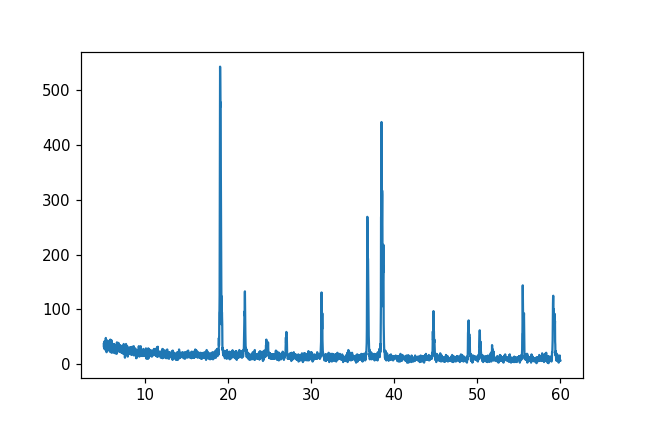

In [5]:
#
# Make sanity checks for example 2: print the metadata, and display
# the diffraction pattern.
#
raw = load_xpd_raw("NN_StartingMaterials_Ba(NO3)2.raw")
print(raw['meta'])
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(raw[0][:,0],raw[0][:,1])

In [6]:
#
# Data Save/Transform Example 2: write the powder X-ray
# diffraction pattern as an x,y csv text file using
# the built-in python csv module.
#
raw = load_xpd_raw("NN_StartingMaterials_Ba(NO3)2.raw")
with open("output-xpd.csv","w",newline='') as f:
    wrt = csv.writer(f)
    for r in raw[0]:
        wrt.writerow(r)